In [1]:
%pip install simpy numpy matplotlib sortedcontainers

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %load_ext autoreload
# %autoreload 2
import simpy
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

from cathousefactory import CatHouseFactory
from cathousefactory import CatFactoryConfig

from customrng import CustomRNG

In [3]:

# ============== #
#     ЗАПУСК     #
# ============== #


def run_simulation():
    
    config = CatFactoryConfig(
        PLANNED_HOUSES_NUM = 50,
        PLANNED_PREMIUM_RATIO = 0.4
    )
    rng = CustomRNG(12345)
    env = simpy.Environment()
    factory = CatHouseFactory(env, config, rng)
    
    for i in range(1, 1000):
        factory.run(until=i*100000)
    
    return factory.get_stats()

stats = run_simulation()

0 Начинается фаза поставки сырья
0: Начата закупка сырья
Запланировано 20 премиум и 30 стандартных домиков
124: Закупка сырья завершена
124: Поставка материалов | Дерево: 710ед, Ткань: 190ед, Краска: 900ед
124 Завершена фаза поставки сырья
124 Начинается фаза производства деталей
124 начало изготовления деталей типов {<WoodenPartType.TYPE2: 2>, <WoodenPartType.TYPE1: 1>, <WoodenPartType.TYPE3: 3>} для дома типа CatHouseType.PREMIUM
Изготавливаем 380 деталей
124 начало изготовления деталей типов {<FabricPartType.TYPE2: 2>, <FabricPartType.TYPE1: 1>} для дома типа CatHouseType.PREMIUM
Изготавливаем 100 деталей
181 конец изготовления деталей типов {<FabricPartType.TYPE2: 2>, <FabricPartType.TYPE1: 1>} для дома типа CatHouseType.PREMIUM
Всего изготовлено деталей 100 из 100
192 Сломалась деталь WoodenPartType.TYPE1
198 Сломалась деталь WoodenPartType.TYPE1
202 Сломалась деталь WoodenPartType.TYPE1
347 Сломалась деталь WoodenPartType.TYPE3
551 Сломалась деталь WoodenPartType.TYPE1
622 Сломал

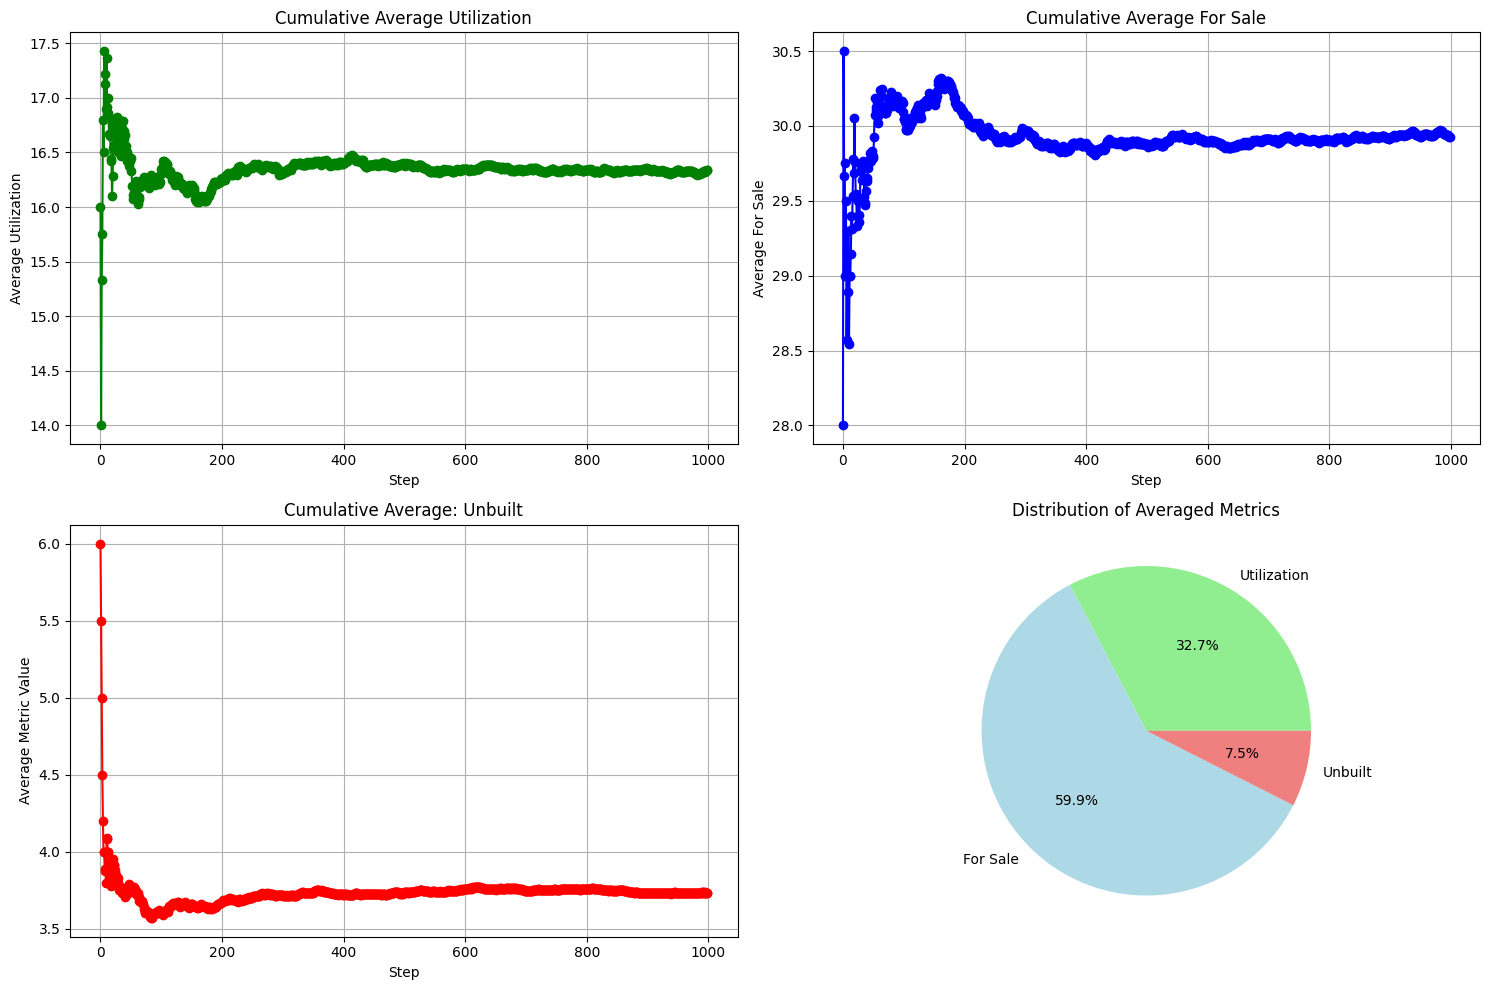

In [4]:
# Визуализация количества бракованных, годных и негодных домиков
for_sale = np.array([d['for_sale'] for d in stats])
for_utilization = np.array([d['for_utilization'] for d in stats])
unbuilt = np.array(
    [d['planned_houses_num'] - d['for_utilization'] - d['for_sale'] for d in stats])

# Накопительные средние
cum_avg_utilization = np.cumsum(for_utilization) / (np.arange(len(for_utilization)) + 1)
cum_avg_sale = np.cumsum(for_sale) / (np.arange(len(for_sale)) + 1)
cum_avg_unbuilt = np.cumsum(unbuilt) / (np.arange(len(unbuilt)) + 1)

plt.figure(figsize=(15, 10))

# Негодные
plt.subplot(2, 2, 1)
plt.plot(cum_avg_utilization, marker='o', color='green')
plt.title('Cumulative Average Utilization')
plt.xlabel('Step')
plt.ylabel('Average Utilization')
plt.grid(True)

# Годные
plt.subplot(2, 2, 2)
plt.plot(cum_avg_sale, marker='o', color='blue')
plt.title('Cumulative Average For Sale')
plt.xlabel('Step')
plt.ylabel('Average For Sale')
plt.grid(True)

# Несделанные
plt.subplot(2, 2, 3)
plt.plot(cum_avg_unbuilt, marker='o', color='red')
plt.title('Cumulative Average: Unbuilt')
plt.xlabel('Step')
plt.ylabel('Average Metric Value')
plt.grid(True)

# Пайчартик соотношения средних
averages = {
    'Utilization': np.mean(for_utilization),
    'For Sale': np.mean(for_sale),
    'Unbuilt': np.mean(unbuilt)
}

plt.subplot(2, 2, 4)
plt.pie(averages.values(), labels=averages.keys(), autopct='%1.1f%%',
        colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title('Distribution of Averaged Metrics')

plt.tight_layout()
plt.show()

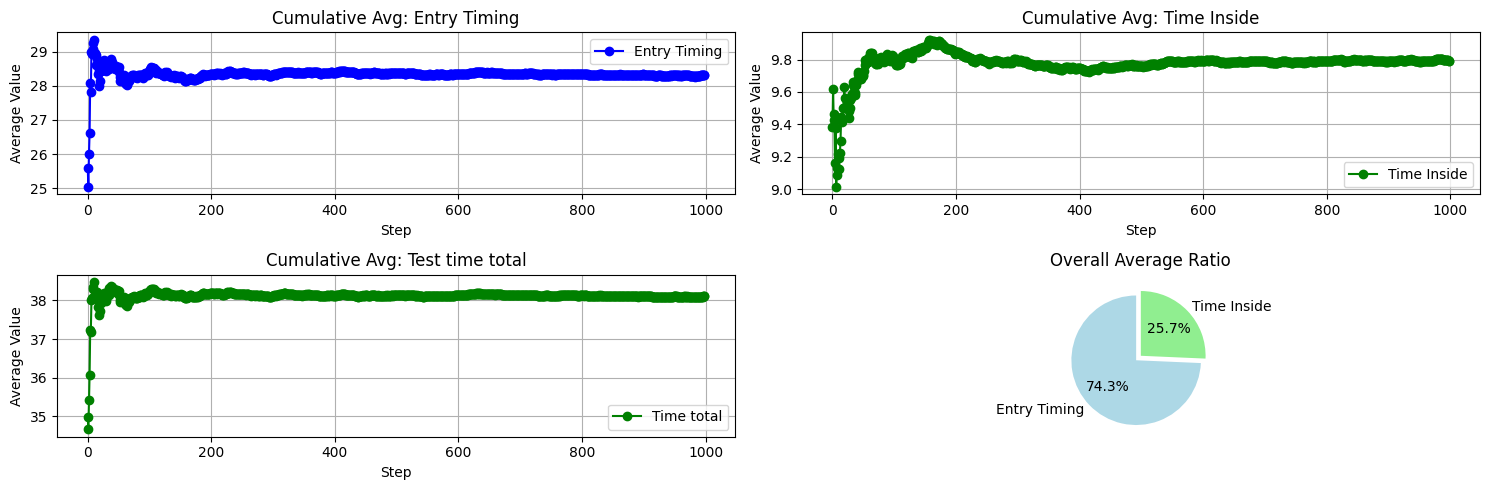

In [5]:

def average_metas(step_metas):
    return {
        'avg_step_entry_timing': sum(
            meta['entry_timing'] if meta['entry_timing'] is not None else 60 
            for meta in step_metas ) / len(step_metas),
        'avg_step_time_inside': sum(
            meta['time_inside'] if meta['time_inside'] is not None else 0
            for meta in step_metas ) / len(step_metas),
        'avg_step_test_time': sum(
            meta['time_inside'] + meta['entry_timing'] if meta['time_inside'] is not None else 60
            for meta in step_metas ) / len(step_metas)
            
    }

avg_metas_by_step = [average_metas(stat['house_testing_metas']) for stat in stats]


entry_timings = np.array([meta['avg_step_entry_timing'] for meta in avg_metas_by_step])
time_insides = np.array([meta['avg_step_time_inside'] for meta in avg_metas_by_step])
avg_step_test_times = np.array([meta['avg_step_test_time'] for meta in avg_metas_by_step])

# Подсчет средних
cum_avg_entry = np.cumsum(entry_timings) / (np.arange(len(entry_timings)) + 1)
cum_avg_time = np.cumsum(time_insides) / (np.arange(len(time_insides)) + 1)
cum_avg_total = np.cumsum(avg_step_test_times) / (np.arange(len(avg_step_test_times)) + 1)

plt.figure(figsize=(15, 5))

# время входа
plt.subplot(2, 2, 1)
plt.plot(cum_avg_entry, marker='o', color='blue', label='Entry Timing')
plt.title('Cumulative Avg: Entry Timing')
plt.xlabel('Step')
plt.ylabel('Average Value')
plt.grid(True)
plt.legend()

# время внутри
plt.subplot(2, 2, 2)
plt.plot(cum_avg_time, marker='o', color='green', label='Time Inside')
plt.title('Cumulative Avg: Time Inside')
plt.xlabel('Step')
plt.ylabel('Average Value')
plt.grid(True)
plt.legend()

# длительность теста
plt.subplot(2, 2, 3)
plt.plot(cum_avg_total, marker='o', color='green', label='Time total')
plt.title('Cumulative Avg: Test time total')
plt.xlabel('Step')
plt.ylabel('Average Value')
plt.grid(True)
plt.legend()

# Пайчартик соотношения захода/внутри
overall_entry = np.mean(entry_timings)
overall_time = np.mean(time_insides)
ratios = [overall_entry, overall_time]
labels = ['Entry Timing', 'Time Inside']
colors = ['lightblue', 'lightgreen']

plt.subplot(2, 2, 4)
plt.pie(ratios, labels=labels, autopct='%1.1f%%', colors=colors,
        startangle=90, explode=(0.1, 0))
plt.title('Overall Average Ratio')

plt.tight_layout()
plt.show()


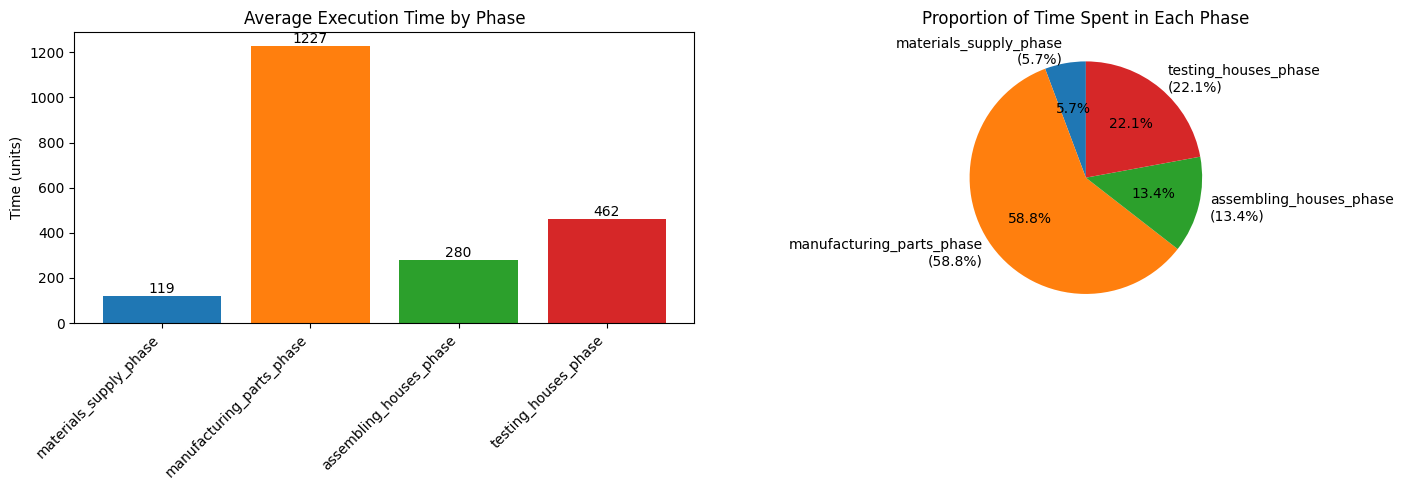

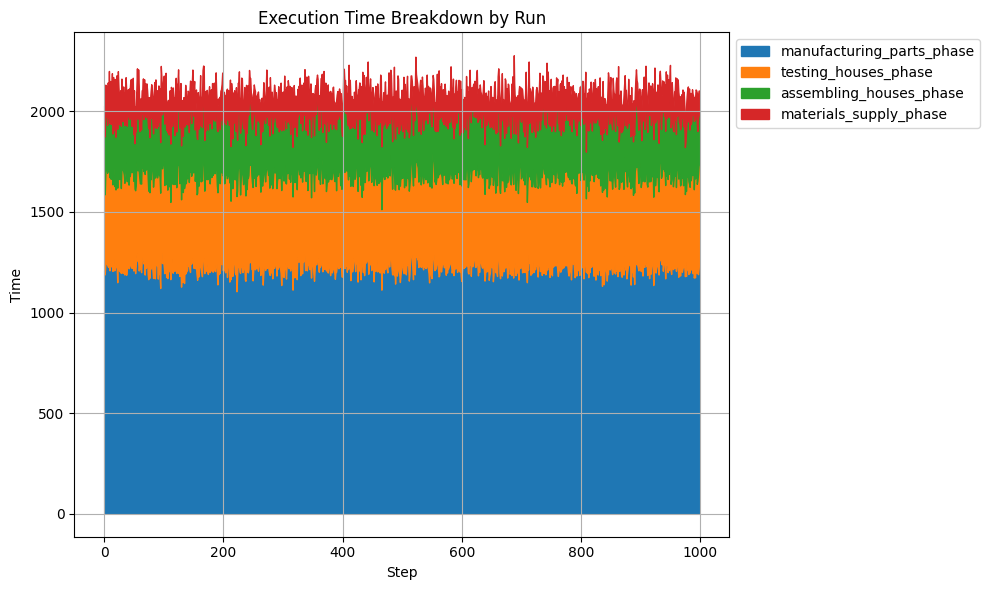

In [6]:
from collections import defaultdict

phase_totals = defaultdict(list)
for entry in stats:
    for phase, time in entry['execution_times_by_phase'].items():
        phase_totals[phase].append(time)

averages = {phase: np.mean(times) for phase, times in phase_totals.items()}
total_avg = sum(averages.values())

plt.figure(figsize=(15, 5))

# Гистограмма со средними временами
plt.subplot(1, 2, 1)
phases = list(averages.keys())
times = list(averages.values())
bars = plt.bar(phases, times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}',
             ha='center', va='bottom')

plt.title('Average Execution Time by Phase')
plt.ylabel('Time (units)')
plt.xticks(rotation=45, ha='right')

# Пайчартик с пропорциями
plt.subplot(1, 2, 2)
labels = [f'{phase}\n({time/total_avg:.1%})' 
          for phase, time in averages.items()]
plt.pie(averages.values(), labels=labels, autopct='%.1f%%',
        colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
        startangle=90)
plt.title('Proportion of Time Spent in Each Phase')

plt.tight_layout()
plt.show()

# График соотношений на каждом шаге 
plt.figure(figsize=(10, 6))
phases_sorted = sorted(averages.keys(), key=lambda x: -averages[x])  # Sort by time descending

for i, phase in enumerate(phases_sorted):
    times = [entry['execution_times_by_phase'][phase] for entry in stats]
    if i == 0:
        plt.fill_between(range(len(stats)), times, label=phase, color=plt.cm.tab10(i))
        bottom = times
    else:
        plt.fill_between(range(len(stats)), np.array(bottom) + np.array(times), bottom, 
                        label=phase, color=plt.cm.tab10(i))
        bottom = np.array(bottom) + np.array(times)

plt.title('Execution Time Breakdown by Run')
plt.xlabel('Step')
plt.ylabel('Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()